# SparseDream with Lateral Inhibition

## Intro
* **Date**: 12/14/2020
* **What**: The title says it all.  This is a SparseDream network with lateral inhibition.  I think I'm going to use an inhibition scheme like in Foldiak's paper, but I might try something else, that's perhaps more (he-hem) ~biologically plausible~.  (Imagine I said that in a high-brow British accent).  By that I mean having some neurons dedicated to inhibition, rather than allowing neurons to have both excitatory and inhibitory synapses.
* **Why**: Lateral inhibition is literally everything.  Especially when there's lateral excitation, the neurons tend to fire together.  They're still firing sparsely, but instead of a couple neurons firing for every input, we're more seeing situations where all neurons are firing for a couple inputs.  So the sparsity factor isn't respected, but that ain't sparsity.  Basically, lateral inhibition steps in to ensure that the neurons aren't firing together.  And, as a myriad of my previous failed experiments attest, if you don't have the sparsity factor, everything goes absolutely haywire.  And thus, my realization in the last experiment: sparsity + inhibition = competition.  And healthy competition is all we've ever wanted.  
* **Hopes**: I'm basically going to train this on mnist in the same way I trained my WTA networks, and I'm hoping I basically see as good of prototypes as I got with the KH network.  That would mean my network is effectively capable of becoming winner-takes-all in that limit, which is great, because that's good evidence that it's actually doing competition.  I then may play around with some more schmeagy configurations and see what I can conjure up.
* **Limitations**: I don't really know.  It seems like when I haphazardly throw lateral inhibition into the picture, things don't work.  I think I have fairly good evidence from the last few experiments to expect some level of success with this, but I can't know for sure.  We'll see!

## Code

In [44]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from scipy.special import expit as sig

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

In [2]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Kx, s_len * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


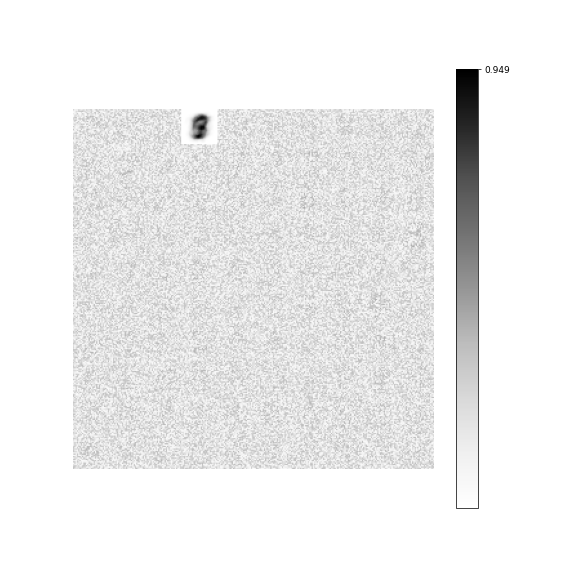

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 416.25it/s]


In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 1
T_s = 1000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.05
sp2 = sp * sp
gamma = 0.01

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.01


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += beta * ((o * o.T) - sp2)
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

## Analysis Dialog

Ok, I think everything's working.  I'm going to train this bad boi on one epoch, see how it goes.  I'm going to forgive that fuzzy three only because I think it'll probably go away.

<IPython.core.display.Javascript object>


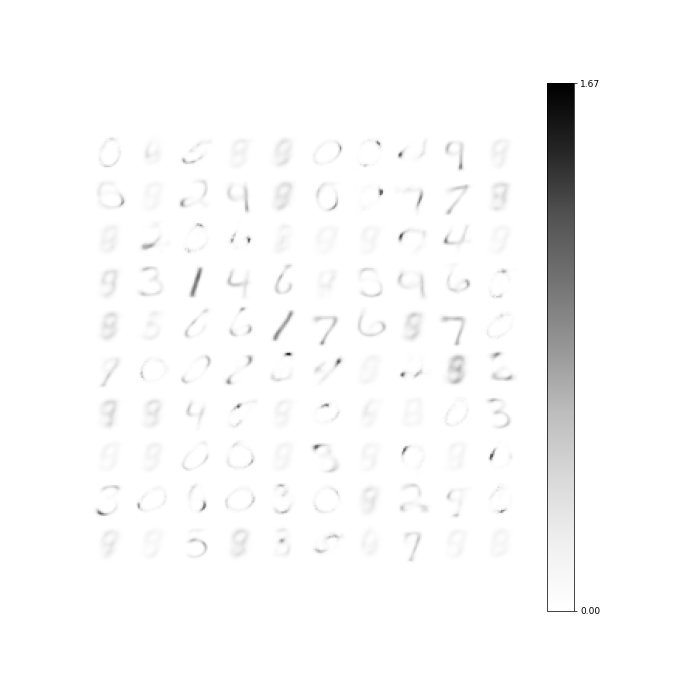

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:33<00:00, 1776.31it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 1
T_s = 60000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.05
sp2 = sp * sp
gamma = 0.01

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.01


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += beta * ((o * o.T) - sp2)
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

Hmm, I just realized I have the sparsity at 0.05, so 5 would be firing at once.  What a goose.  Also, I'm going to bump gamma up to sparsify things.

If it wasn't clear, I'm going to set `sp = 0.01` so that the network is effectively doing wta.

<IPython.core.display.Javascript object>


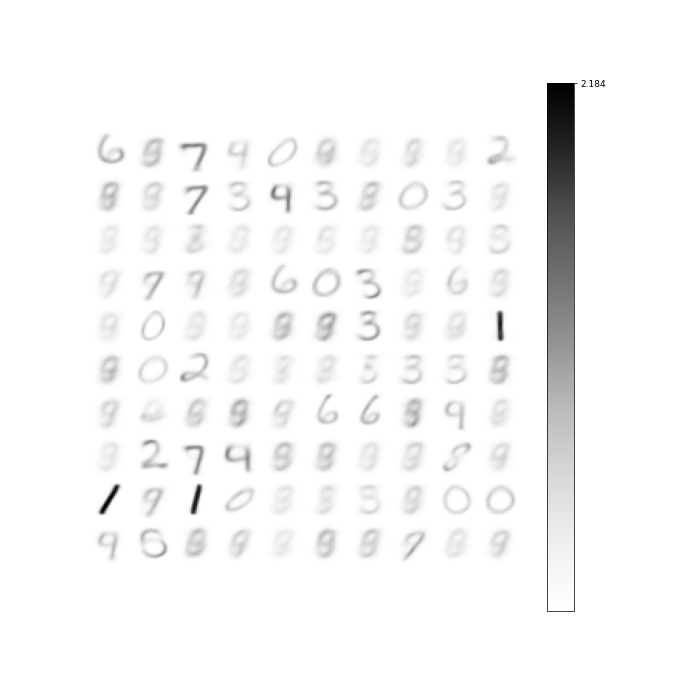

100%|███████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1745.35it/s]


In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 20
T_s = 3000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 0.5

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.01


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += beta * ((o * o.T) - sp2)
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

...that's...weird.  I'm going to mess around with this a bit.  I'll let you know what I find.

<IPython.core.display.Javascript object>


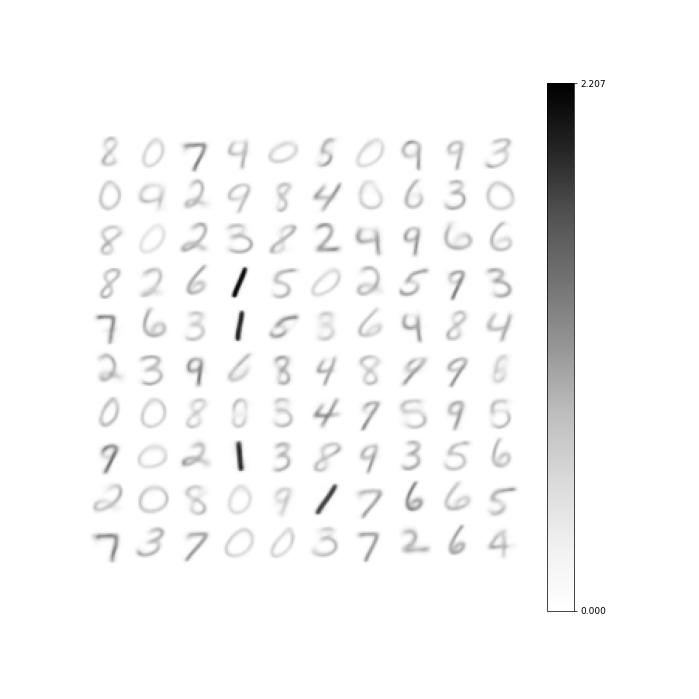

100%|███████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1720.88it/s]


In [24]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 40
T_s = 3000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.01


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

Ok, first things first, I realized I wasn't zeroing the diagonals of the lateral inhibition matrix, which is basically algorithmically undefined behavior.  That basically means the neurons were inhibiting themselves proportional to themselves, which is no good whatsoever.  

The coefficient that I think give me the juice, (ie the good prototypes of last run), are fairly low values of `xi` and `beta`, and a high `gamma`.  So yeah, I'm going to continue boosting gamma until things go wrong.

<IPython.core.display.Javascript object>


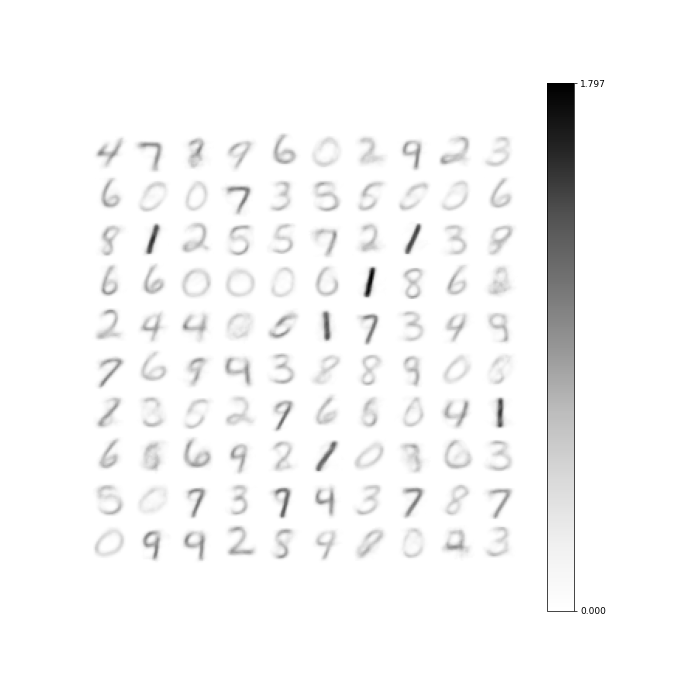

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1678.96it/s]


In [38]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 20

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

Ok, I have a couple things to report.  First things first, I think I might take my realization back.  I don't think you need lateral inhibition to get pure competition.  I think you just need a very large `gamma`.  You'll notice in the last network, `gamma = 20`.  That's somewhat egregious.  However, at the same time, a super large gamma is effectively insuring that an input will only fire at the rate of the sparsity constant, because once it's fired, it's threshold gets way too big to fire again any time soon.  However, that's actually not great, because there's nothing inherent saying a particular prototype won't come up with a frequency of `sp`.  Wow, there were so many negatives in that sentence, I don't even know what to do with myself.  

Ok.  To check out the difference of using different gammas, I'm going to do four trials.

<IPython.core.display.Javascript object>


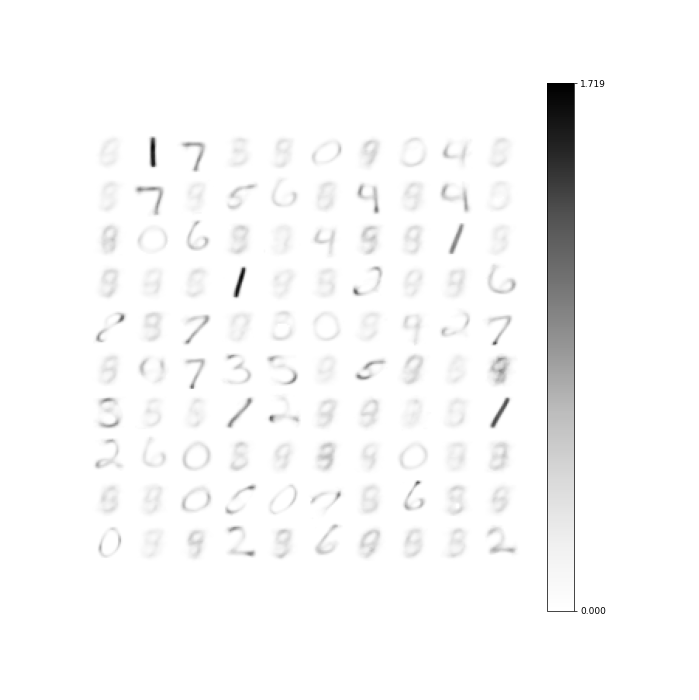

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1715.87it/s]


In [39]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 0.1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


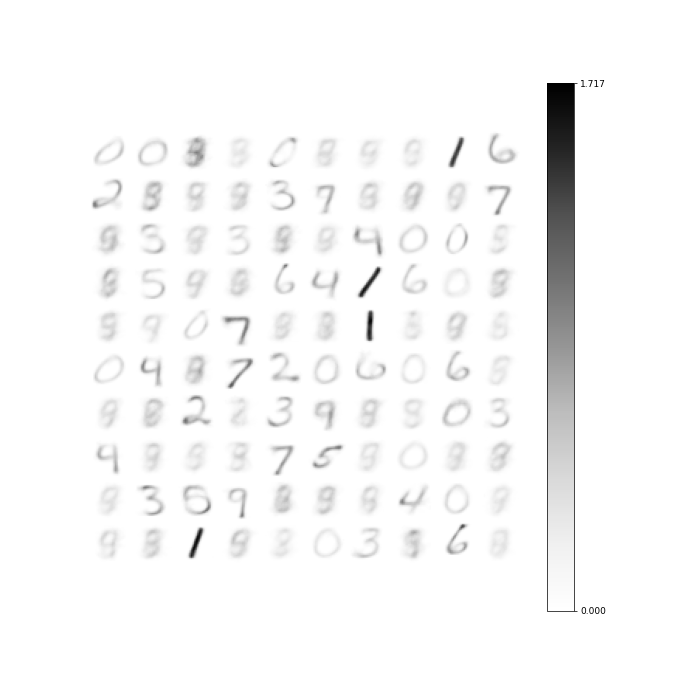

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1700.06it/s]


In [40]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 0.5

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


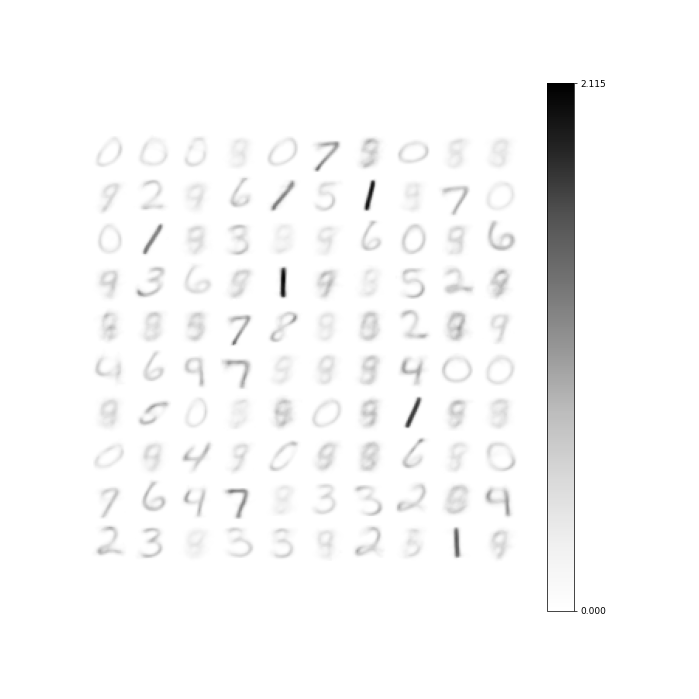

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1683.78it/s]


In [41]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


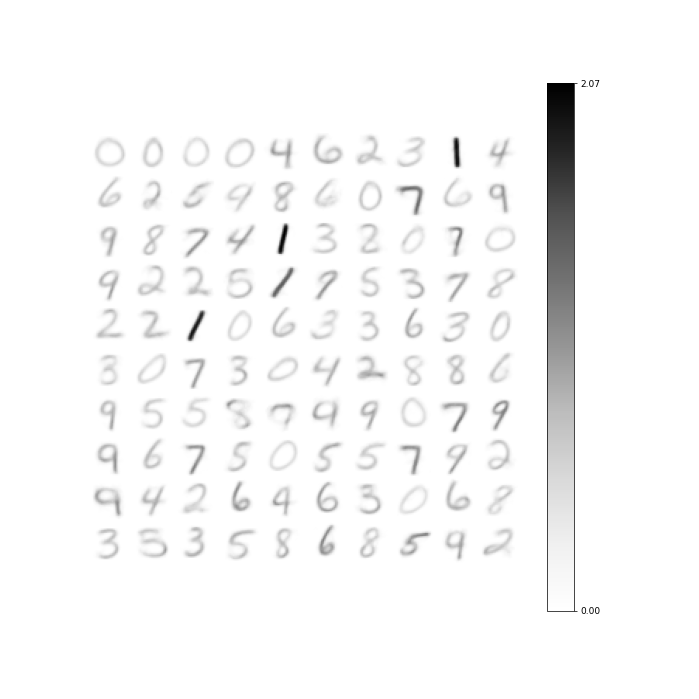

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1707.36it/s]


In [42]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 5

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


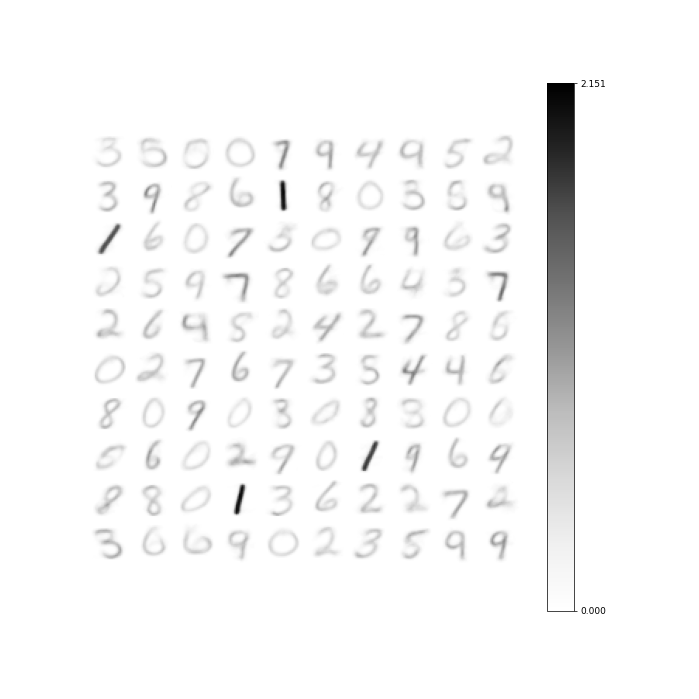

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1681.69it/s]


In [43]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 10

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)

Yeah, there are a lot of fluctuations.  You know, I should really bring in the wta classifier to actually have a metric.

In [45]:
def wta_classification(w):
    flat_x = m_flat_tr
    flat_test = m_flat_te
    
    v = flat_x
    train_lbls = train_y
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w @ (flat_x).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [46]:
wta_classification(w)

Neuron classes: [3 5 0 0 7 9 4 4 5 2 3 9 8 6 1 8 0 3 5 9 1 6 0 7 5 0 9 9 6 3 2 5 9 7 8 6 6
 4 3 7 2 6 4 5 2 4 2 7 8 5 0 2 7 6 7 3 5 4 4 5 8 0 9 0 3 0 8 3 0 6 5 6 0 2
 9 0 1 9 6 9 8 8 0 1 3 6 2 2 7 2 3 6 6 9 0 2 3 5 9 9]
Accuracy: 81.8%
Misclassifieds:  [125.  12. 124. 190. 444. 203.  50. 203. 300. 169.]


Sweet.  Now we have an actual metric. I'm going to do `gamma = 5` again.

<IPython.core.display.Javascript object>


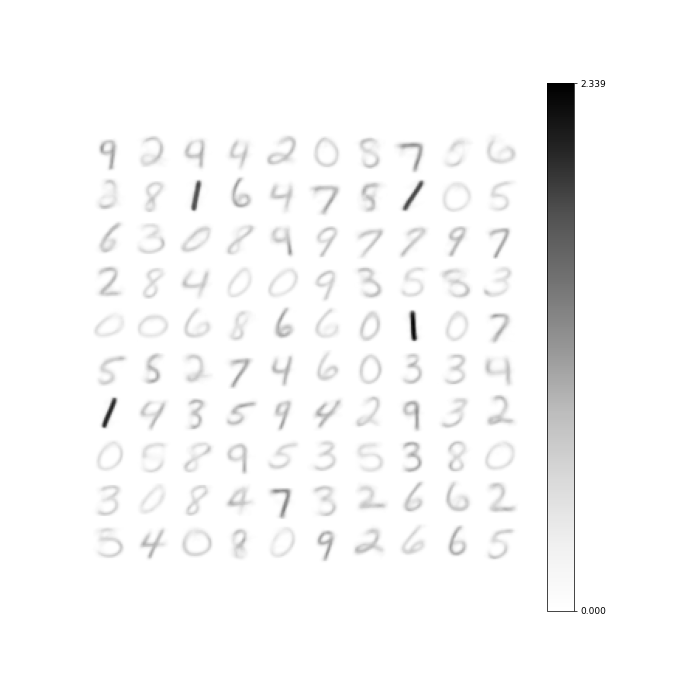

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1718.47it/s]


Neuron classes: [9 2 4 4 2 0 8 7 5 6 3 8 1 6 4 7 5 1 0 5 6 3 0 8 4 9 7 7 9 7 2 8 4 0 0 9 3
 5 8 3 0 0 6 8 6 6 0 1 0 7 5 5 2 7 4 6 0 3 3 4 1 4 3 5 9 4 2 9 3 2 0 5 8 9
 5 3 5 3 8 0 3 0 8 4 7 3 2 6 6 2 5 4 0 8 0 9 2 6 6 5]
Accuracy: 84.48%
Misclassifieds:  [ 60.  18. 158. 117. 232. 178.  38. 174. 278. 299.]


In [47]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 5

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)

<IPython.core.display.Javascript object>


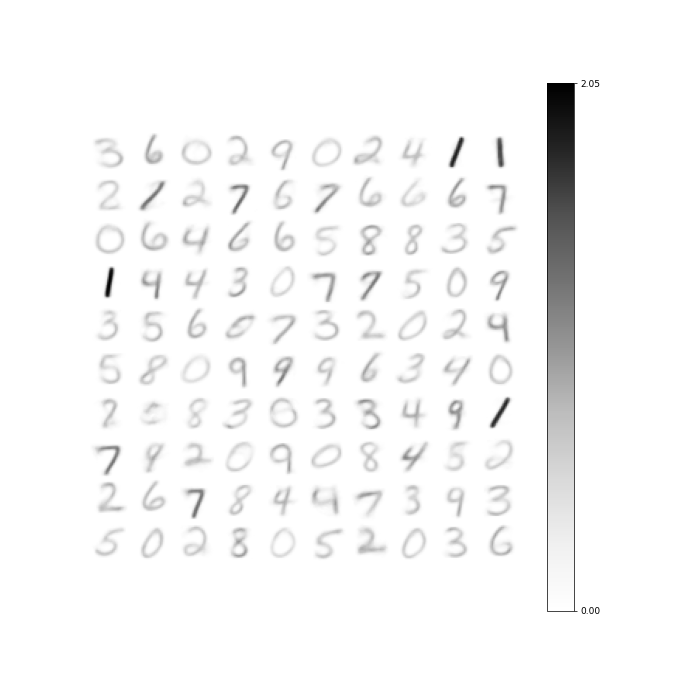

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1680.73it/s]


Neuron classes: [3 6 0 2 9 0 2 4 1 1 2 1 2 7 6 7 6 6 6 7 0 6 4 6 6 5 8 8 3 5 1 4 4 3 0 7 7
 5 0 9 3 5 6 5 7 3 2 0 2 4 5 8 0 9 9 9 6 3 4 0 2 5 8 3 0 3 3 4 9 1 7 4 2 0
 9 0 8 4 5 2 2 6 7 8 4 4 7 3 9 3 5 0 2 8 0 5 2 0 3 6]
Accuracy: 85.41%
Misclassifieds:  [ 69.  13. 102. 152. 211. 172.  38. 173. 275. 254.]


In [48]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.05

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 5

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)

LOOOOOOLLLLLL!!! That's actually kinda hilarious.  This is getting a better classification accuracy than Diehl's network.  First of all, take that Diehl!  Not responding to my email, that's what you get!  Anyway, you know what this means?  I'll bet the reason why Diehl's network worked even a little bit is because of the homeostasis term.  Oh, I just realized that the wta classification normalizes the weights.  Hmm.  Let's see what happens if I *don't* normalize the weights.

In [49]:
def wta_classification_non_norm(w):
    flat_x = m_flat_tr
    flat_test = m_flat_te
    
    v = flat_x
    train_lbls = train_y
    
    wins = np.argmax(w @ (flat_x).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [50]:
wta_classification_non_norm(w)

Neuron classes: [3 6 0 2 9 0 2 0 1 1 0 2 0 7 6 7 6 0 6 7 0 6 4 0 6 0 8 0 3 5 1 4 4 3 0 7 7
 0 0 9 0 5 6 0 0 3 0 0 2 4 0 8 0 9 4 0 0 0 4 0 0 0 0 3 0 3 3 4 9 2 7 0 2 0
 9 0 0 4 0 0 2 6 7 0 0 4 7 0 0 3 0 0 2 5 0 5 2 0 5 0]
Accuracy: 48.08%
Misclassifieds:  [366. 218. 440. 787. 360. 828. 346. 202. 844. 801.]


Shoot dang!! Wait, if I'm going to do that, I should at least include `t` and `lat_in` in there.

In [69]:
def wta_classification_sparse(w, t, lat_in):
    flat_x = m_flat_tr
    flat_test = m_flat_te
    
    v = flat_x
    train_lbls = train_y
    
    w_v = w @ v.T
    p = sig(w_v - t)
    o = sig(w_v - (lat_in @ p) - t)
    
    print(o.shape)
    
    wins = np.argmax(o, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_v = w @ test_v[i].reshape(-1, 1)
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        n_max = np.argmax(o)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [70]:
wta_classification_sparse(w, t, lat_in)

(100, 60000)
Neuron classes: [3 6 0 2 9 0 2 4 1 1 2 1 2 7 6 8 6 6 6 7 0 6 4 6 6 5 8 8 3 5 1 4 4 3 0 7 7
 5 0 9 3 5 6 0 7 3 2 0 2 4 5 8 0 9 9 9 6 3 4 0 7 5 1 3 0 3 3 4 9 1 7 4 2 0
 9 0 8 4 0 2 2 6 7 8 4 4 7 3 9 3 5 0 2 8 0 5 2 0 3 6]
Accuracy: 73.98%
Misclassifieds:  [180. 113. 247. 383. 171. 276. 116. 215. 473. 428.]


Ok, that's marginally better.  Let's see what I can cook up with lateral inhibition.

<IPython.core.display.Javascript object>


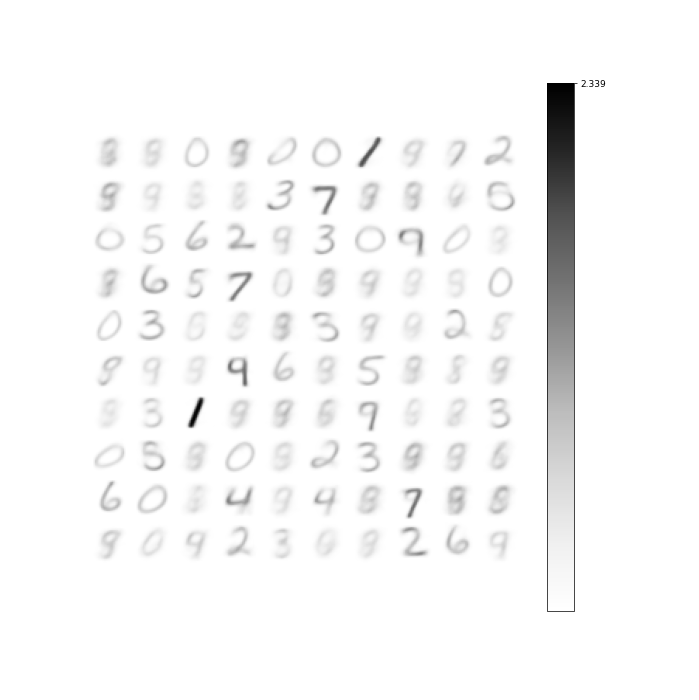

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1691.54it/s]


Neuron classes: [2 8 0 5 0 0 1 5 9 2 8 4 3 8 3 7 3 8 4 5 0 5 6 2 8 3 0 9 0 7 7 6 5 7 0 3 9
 2 8 0 0 3 5 3 3 3 9 4 2 5 8 9 3 4 6 8 5 8 1 9 8 3 1 4 4 4 7 6 8 3 0 3 8 0
 8 2 3 4 8 6 6 0 5 4 2 4 8 7 8 5 8 0 4 2 3 4 8 2 6 9]
Accuracy: 72.97%
Misclassifieds:  [ 72.  42. 221. 138. 324. 365. 100. 195. 556. 690.]
(100, 60000)
Neuron classes: [0 0 0 0 0 0 1 0 0 2 0 0 0 0 3 7 0 0 4 0 0 5 6 2 0 0 0 9 0 1 0 6 5 7 0 8 0
 0 7 0 0 3 0 0 0 3 0 0 2 5 0 7 0 9 6 0 5 0 1 0 5 3 1 0 0 0 7 6 0 0 0 5 0 0
 0 2 3 0 0 0 0 0 0 4 0 0 0 7 0 0 0 0 0 2 3 0 0 2 6 0]
Accuracy: 38.18%
Misclassifieds:  [561. 382. 584. 835. 869. 710. 680. 693.  26. 842.]


In [74]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.02


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

<IPython.core.display.Javascript object>


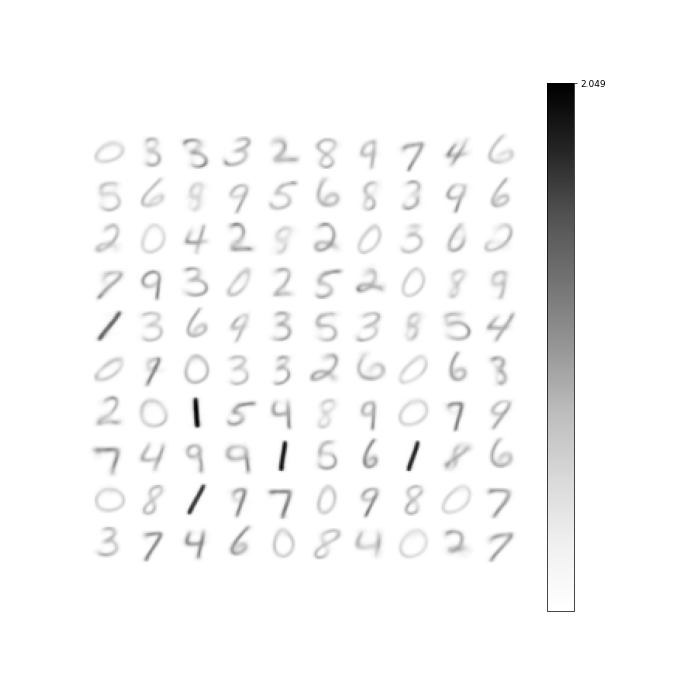

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1674.88it/s]


Neuron classes: [0 3 3 3 2 8 4 7 4 6 5 6 8 9 5 6 8 3 9 6 2 0 4 2 8 2 0 3 0 2 7 9 3 0 2 5 2
 0 8 9 1 3 6 9 3 5 3 8 5 4 0 7 0 3 3 2 6 0 6 3 2 0 1 5 4 8 9 0 7 9 7 4 9 9
 1 5 6 1 8 6 0 8 1 7 7 0 9 8 0 7 3 7 4 6 0 8 4 0 2 7]
Accuracy: 83.22%
Misclassifieds:  [ 35.  19. 116. 120. 321. 299.  62. 149. 274. 283.]
(100, 60000)
Neuron classes: [0 8 3 3 2 8 4 7 4 6 5 6 4 0 5 6 8 3 9 6 2 0 4 2 1 2 0 3 0 2 7 9 3 5 2 5 2
 0 8 0 1 3 6 4 3 5 3 0 5 4 0 7 0 3 3 2 6 0 6 8 2 0 1 5 4 8 9 0 7 9 7 4 9 9
 1 5 6 1 8 0 0 8 1 0 7 0 9 8 0 7 3 7 4 6 0 8 4 0 2 7]
Accuracy: 74.46%
Misclassifieds:  [282.  67.  77. 172. 478. 290.  98. 465. 482. 143.]


In [75]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

<IPython.core.display.Javascript object>


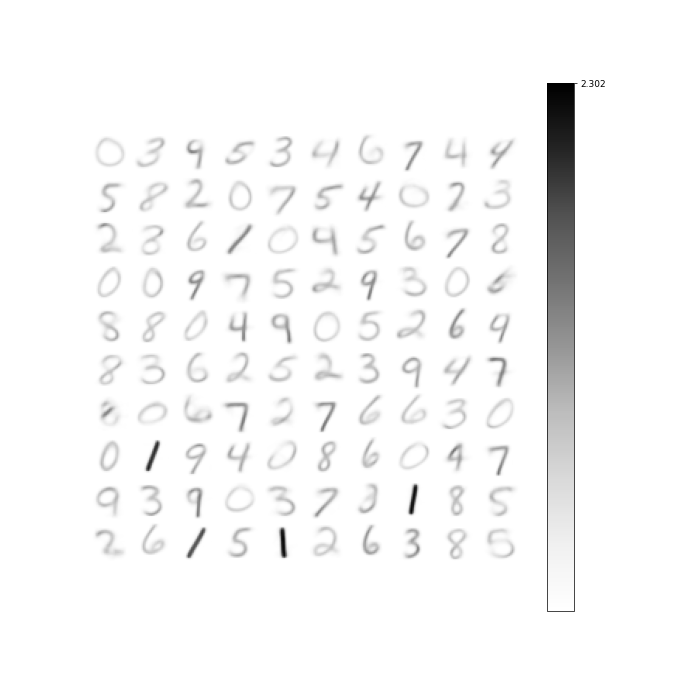

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1709.22it/s]


Neuron classes: [0 3 9 5 3 4 6 7 4 4 5 8 2 0 7 5 4 0 2 3 2 3 6 1 0 4 5 6 7 8 0 0 9 7 5 2 9
 3 0 5 8 8 0 4 9 0 5 2 6 9 8 3 6 2 5 2 3 9 4 7 2 0 6 7 2 7 6 6 3 0 0 1 9 4
 0 8 6 0 4 7 9 3 9 0 3 7 3 1 8 5 2 6 1 5 1 2 6 3 8 5]
Accuracy: 86.39%
Misclassifieds:  [ 44.  13. 165. 116. 258. 133.  51. 173. 210. 198.]
(100, 60000)
Neuron classes: [0 3 9 5 3 4 6 7 4 4 5 8 2 0 7 5 4 0 2 3 2 3 6 1 0 4 5 6 7 2 0 0 9 7 5 2 9
 3 0 5 8 8 0 4 9 0 5 2 6 9 8 3 6 2 5 2 3 9 4 7 8 0 6 7 2 7 6 6 3 0 0 1 9 4
 0 8 6 1 4 7 9 3 9 0 3 7 3 1 8 5 2 6 1 5 1 2 6 3 8 5]
Accuracy: 80.83%
Misclassifieds:  [222.  21. 272. 155. 321. 142.  63. 136. 342. 243.]


In [76]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.005


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

<IPython.core.display.Javascript object>


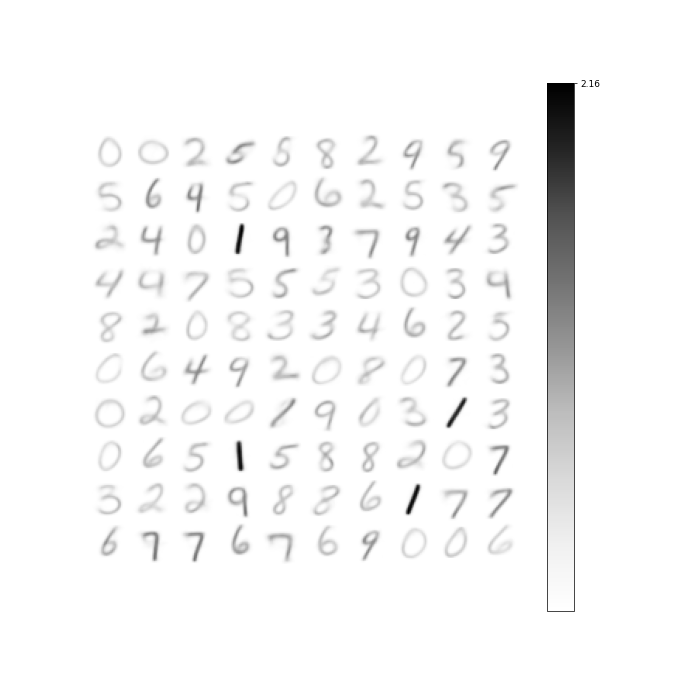

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1657.96it/s]


Neuron classes: [0 0 2 5 5 8 2 9 5 9 5 6 4 5 0 6 2 5 3 5 2 4 0 1 9 3 7 9 4 3 4 4 7 5 5 5 3
 0 3 4 8 2 0 8 3 3 4 6 2 5 0 6 4 9 2 0 8 0 7 3 0 2 0 0 1 9 0 3 1 3 0 6 5 1
 5 8 8 2 0 7 3 2 2 9 8 8 6 1 7 7 6 7 7 6 7 6 9 0 0 6]
Accuracy: 86.19%
Misclassifieds:  [ 23.  12. 105. 168. 297.  88.  48. 143. 225. 272.]
(100, 60000)
Neuron classes: [0 0 2 5 5 8 2 9 5 9 5 6 4 5 0 6 2 5 3 5 2 4 0 1 9 3 7 9 4 3 4 4 7 5 5 5 3
 0 3 4 8 2 0 8 3 3 4 6 2 5 1 6 4 9 2 0 8 0 7 3 0 2 0 0 8 9 0 3 1 3 0 6 5 1
 5 8 8 2 0 7 3 2 2 9 8 8 6 1 7 7 6 7 7 6 7 6 9 0 0 6]
Accuracy: 82.15%
Misclassifieds:  [122.  46. 184. 150. 314. 117. 110. 167. 309. 266.]


In [77]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.001


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

<IPython.core.display.Javascript object>


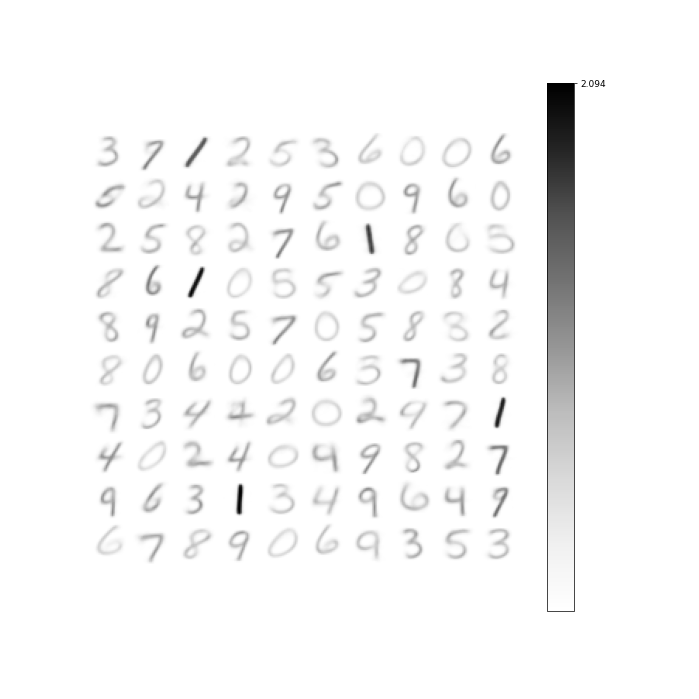

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1683.07it/s]


Neuron classes: [3 7 1 2 5 3 6 0 0 6 5 2 4 2 9 5 0 9 6 0 2 5 8 2 7 6 1 8 6 5 8 6 1 0 5 5 3
 0 8 4 8 9 2 5 7 0 5 8 8 2 8 0 6 0 0 6 3 7 3 8 7 3 4 2 2 0 2 4 7 1 4 0 2 4
 0 4 9 8 2 7 9 6 3 1 3 4 9 6 4 7 6 7 8 9 0 6 9 3 5 3]
Accuracy: 85.91%
Misclassifieds:  [ 72.  16. 107. 185. 265. 158.  26. 140. 163. 277.]
(100, 60000)
Neuron classes: [3 7 1 2 5 3 6 0 0 6 5 2 4 2 9 5 0 9 6 0 2 5 8 2 7 6 1 8 6 5 8 6 1 0 5 5 3
 0 8 4 8 9 2 5 7 0 5 8 8 2 8 0 6 0 0 6 5 7 3 8 7 3 4 4 2 0 2 4 7 1 4 1 2 4
 0 4 9 8 2 7 9 0 3 1 3 4 9 6 4 7 6 7 8 9 0 6 9 3 5 3]
Accuracy: 82.12%
Misclassifieds:  [197.  30. 125. 159. 174. 266.  68. 148. 296. 325.]


In [78]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 10
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0005


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

Wow, so adding some very light lateral inhibition actually does help the accuracy.  You'll notice that I've gotten the sparse wta classifier into the ballpark of Diehl's network.  I'm going to mess around a bit with the coefficients to see if I can get it up even higher.

<IPython.core.display.Javascript object>


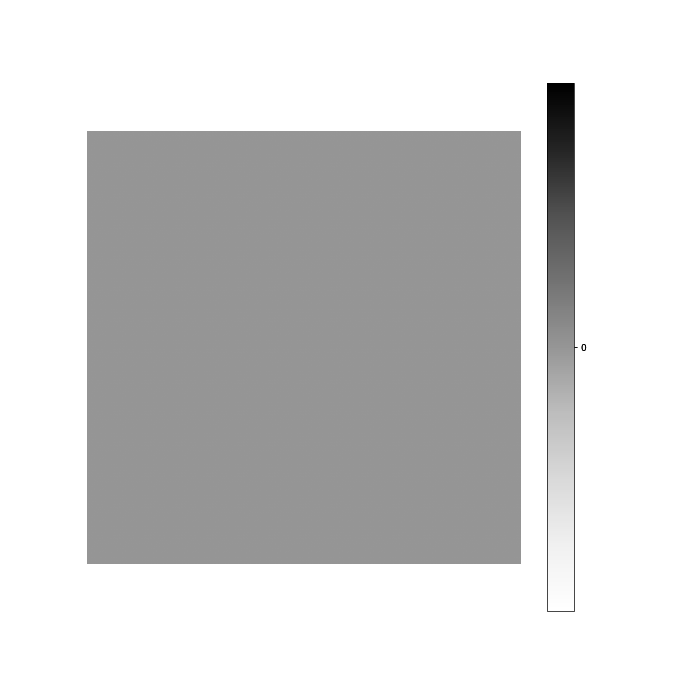

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1696.50it/s]


Neuron classes: [7 5 2 7 6 7 0 5 3 9 8 3 0 5 1 4 6 2 5 4 6 4 6 2 7 0 0 5 6 1 3 2 7 1 9 5 4
 3 0 0 8 6 6 7 4 7 6 5 0 3 0 6 0 0 7 4 3 3 5 3 3 8 5 0 5 6 0 8 2 0 0 9 0 9
 2 0 8 4 4 8 2 9 2 0 2 9 2 4 7 3 1 9 9 7 2 9 8 5 0 6]
Accuracy: 86.68%
Misclassifieds:  [ 23.  12. 101. 172. 256. 135.  51. 104. 280. 198.]
(100, 60000)
Neuron classes: [7 5 2 7 6 7 0 5 3 9 8 3 0 5 1 4 6 2 5 4 6 4 6 2 7 0 0 5 6 1 3 2 7 1 9 5 4
 3 0 0 8 6 6 7 4 7 6 5 0 3 0 6 0 0 7 4 3 3 5 3 3 8 5 0 5 6 0 8 2 0 1 9 0 9
 2 0 8 4 4 8 2 9 2 0 2 9 2 4 7 3 1 9 9 7 2 9 8 5 0 6]
Accuracy: 81.59%
Misclassifieds:  [ 94.  52. 170. 227. 230. 196.  73. 153. 416. 230.]


In [104]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 20
T_s = 6000
Kx = 10
Ky = 10
N = Kx * Ky
prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.01

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0005


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        lat_in += ((o * o.T) - sp2) * beta
        np.fill_diagonal(lat_in, 0)
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

Ok, I think the trials above where I got 82% both times were acts of god.  I ran those trials again a couple times, and the sparse classifier typically gets around 78%.  Actually, wait I didn't run the trial with `beta = 0.0005` more than once.  That might be the juice.  In any event, the lateral inhibition has to be super super light.  

Actually, I ran the `beta = 0.0005` again, and it was actually doing pretty poorly.  So it basically just looks like a dance of hyperparameters.

Hmm, well at least I know how to recreate Diehl's network, at least to a certain degree.  Before I wrap this experiment up, I'm going to see if I can batch this algorithm.

In [115]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Nep = 1
T_s = 60000
prec = 1e-10
B = 100
Kx = 10
Ky = 10
N = Kx * Ky

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.01

# Initialize sparsity threshold
t = np.zeros((N, 1))
sp = 0.01
sp2 = sp * sp
gamma = 1

# Initialize lateral inhibition
lat_in = np.zeros((N, N))
beta = 0.0005


for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :].T
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v - (lat_in @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
#         print(o.shape)
        
        o_o = (o * o.reshape(-1, 1, B)) - sp2
        o_o_sum = np.sum(o_o, axis=2)
        max_o_o = np.max(np.abs(o_o_sum))
        
        if max_o_o < prec:
            max_o_o = prec
            
        lat_in += (beta / max_o_o) * o_o_sum
        np.fill_diagonal(lat_in, 0)
        
        o_e = o.reshape(-1, 1, B) * (e / mod_r)
        o_e_sum = np.sum(o_e, axis=2)
        max_o_e = np.max(o_e_sum)
        
        if max_o_e < prec: 
            max_o_e = prec
            
        w += (xi / max_o_e) * o_e_sum * w
        
        o_sum = np.sum(o - sp, axis=1)
        max_o = np.max(o_sum)
        
        if max_o < prec:
            max_o = prec
            
#         print(o_sum.shape)
        t += (gamma / max_o) * o_sum.reshape(-1, 1)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)

    draw_weights(w, Kx, Ky, 28, fig)
    
wta_classification(w)
wta_classification_sparse(w, t, lat_in)

<IPython.core.display.Javascript object>

 13%|████████▌                                                       | 80/600 [00:04<00:26, 19.54it/s]


KeyboardInterrupt: 

Well, something's broken.  However, it appears that this "mini-batching" isn't speeding anything up.  Rip.  Well, whatever.  I don't like algorithm acceleration anyway. \**sniff*\*  Ok, I'm going to finish this experiment up.

## Conclusions

Well, it appears that whole sparsity + inhibition = competition isn't exactly true.  If the data is all shuffled, then I can just boost the learning constant on the sparsity term to essentially ensure that neurons are only firing according to the sparsity coefficient.  However, the inhibition was somewhat helping the network find better prototypes.  I think.  That actually wasn't exactly clear.  

I think inhibition is especially important when I have lateral excitation afoot in the network.  

But I should talk about Diehl.  I think the homeostasis term is doing most of the work, and the lateral inhibition actually isn't doing that much.  In terms of prototype creation, that is.  

Anything else?  I tried to mini-batch this bad boi, and it didn't really work.  That's kinda a major bummer.  I guess I'll need to figure out how to speed up the network using other means.

## Next steps

Hhhhhheerrrmmmm.  Well, I think the thing to do is to hook add lateral inhibition to a topographical SparseDream network.  I'm trying to think if there's anything else I should do.  Maybe mess with Hopfield networks?  Maybe finally learn how to use my FPGA?  Learn Cuda?  Hook up AWS?  Yeah, I should probably do all of that.  But I think topographical SparseDream is the way to go.

Yeah I'll do that.